# 1. DATA WRANGLING




In [137]:
import os
import pandas as pd
import numpy as np

To begin with, I have iterated through the folders containing all the students csv's.

In my iteration, I have enforced a couple rules to ensure each file is appended successfully, these are:
* __`pd.read_csv(path, dtype=object)`__ - Many of the columns I am appending have mixed datatypes so I am setting all the columns to string to ensure there are no errors and will perform column operations to clean these in a later step.
* __`str.lower, str.strip`__ - I have used these two string operations in an attempt to minimize column name differences. This results in the whole string lowercased with all whitespaces removed. Even with these two operations, this revealed an excessive amount of core columns columns specified in the instructions worded differently.
* __`dropna(how='all')`__ - When pandas reads in a csv, if there is a formatted table extending beyond the data entries, this is read as null rows by default in the dataframe. In one particular case there was over 1m rows (22351482.csv). This method eliminates these cases.

Finally, I also assigned 3 columns to each csv which will help in handling, producing general count statistics and identifying files, these are: __`file_idx`__ - a unique file ID, __`file_name`__ - the name of the file, __`folder_name`__ - the folder this column is located in.


In [138]:
appended_raw = pd.DataFrame()

ticker=0
for folder in os.listdir(r'DATA'):
    if folder.startswith('csv'):
        year_files = os.listdir(r'DATA/' + folder)
        for file in year_files:
            if file.endswith('.csv'):

                ticker += 1

                tmp_file = pd.read_csv(r'DATA/' + folder + '/' + file, dtype=object)
                tmp_file.dropna(how='all', inplace=True)

                tmp_file.columns = map(str.lower, tmp_file.columns)
                tmp_file.columns = map(str.strip, tmp_file.columns)

                tmp_file['file_idx'] = ticker
                tmp_file['file_name'] = file
                tmp_file['folder_name'] = folder
                
                appended_raw = appended_raw.append(tmp_file)

print(appended_raw.info(), '\n')
print(appended_raw.columns)
appended_raw.head()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 12936 entries, 0 to 139
Columns: 162 entries, date to undergraduate driver
dtypes: int64(1), object(161)
memory usage: 16.1+ MB
None 

Index(['date', 'time', 'direction', 'type', 'occupancy', 'color',
       'public/private', 'file_idx', 'file_name', 'folder_name',
       ...
       'public transport', 'car company/bus no', 'busno',
       'transport type (public/private)', 'pedestrian count',
       'type of transportation', 'bus type', 'temperature (c)',
       'cumulative frequency', 'undergraduate driver'],
      dtype='object', length=162)


,date,time,direction,type,occupancy,color,public/private,file_idx,file_name,folder_name,...,public transport,car company/bus no,busno,transport type (public/private),pedestrian count,type of transportation,bus type,temperature (c),cumulative frequency,undergraduate driver
0,23/10/2023,10.30am,out,car,0.2,grey,private,1,22792703.csv,csv_data_2023,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,23/10/2023,10.30am,out,car,0.2,other,private,1,22792703.csv,csv_data_2023,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,23/10/2023,10.30am,out,car,0.2,grey,private,1,22792703.csv,csv_data_2023,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,23/10/2023,10.30am,out,van,0.5,white,public,1,22792703.csv,csv_data_2023,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,23/10/2023,10.30am,out,van,1,NaN,public,1,22792703.csv,csv_data_2023,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


The purpose of this cell is to export an excel with all the raw column names not included in the 5 standard columns required in the spec.

This excel will contain 3 columns: 
* __`raw_column`__ - the column not in our standard columns list. Most of the time this will be the unique columns the group chose to include for their research question. In some cases groups have not followed the specification instructions in naming these columns so these will also have to be identified.
* __`file`__ - the name of the file
* __`folder`__ - the folder the column is located in
* __`sample_values`__ - 5 sample values of the column to allow us to tag it to an appropriate column

This will expedite the process of searching and uderstanding the columns. Once I have my helper search file, I will create a lookup file / dimension table with the unique column names which will manually map onto a second column 'column_mod' used to rename all the columns I have concluded are referring to the same observation to the same column name. This lookup file will then be used in the iteration which joins all the csv's to ensure these observations are appended in the same column. After this step is completed I will then be able to apply rules to the column to set values to a predefined format which can be used in my analysis.

In [139]:
column_map = appended_raw.copy()
column_map = column_map[column_map.columns[~column_map.columns.isin(['date', 'time', 'direction', 'type', 'occupancy', 'file_idx'])]]
column_map = pd.melt(column_map, id_vars=['folder_name', 'file_name'], var_name='raw_column', ignore_index=1).dropna(subset=['value'])
column_map = column_map.groupby(['folder_name', 'file_name', 'raw_column'], as_index=False).agg({'value':lambda x: list(x)})
column_map = column_map.reset_index(drop=True).rename(columns={'value': 'sample_values'})
column_map['sample_values'] = column_map['sample_values'].apply(lambda x: x[:5])

# Reference file for every occurence of the column name. This excel will expediate understanding what the column is referring to so I can assign a column name to it in the next step. 
# 'column_mod' is filled out manually and is the lookup value raw_column should be renamed to.
column_map = column_map.sort_values(by='raw_column')
lookup = pd.read_excel(r'DATA/unique_raw_columns.xlsx')
column_map = pd.merge(column_map, lookup, how='inner', on='raw_column')
column_map.to_excel(r'DATA/column_reference.xlsx', index=False)

column_map.head()

,folder_name,file_name,raw_column,sample_values,column_mod
0,csv_data_2023,22792702.csv,additionaldata1,"[No, No, No, No, No]",unwanted
1,csv_data_2023,22792780.csv,additionaldata2,"[ null, null, null, null, null]",unwanted
2,csv_data_2022,22351436.csv,additionaldata2,"[ null, null, null, null, null]",unwanted
3,csv_data_2023,22792737.csv,age group,"[30 - 34, under 30, 30 - 34, 30 - 34, above 45]",unwanted
4,csv_data_2023,22792798.csv,age group,"[30 - 45, 30 - 45, 30 - 45, 30 - 45, 30 - 45]",unwanted


This is essentially the point where the wrangling begins. 

In this step I am using the lookup file I created `column_reference.xlsx` to change the names of the columns I want to keep which have been recorded by different groups but are a reference to the same observation. In the lookup file I have also identified columns which were supposed to be core columns defined in the spec release and corrected them.

Following the same iterative logic appending the raw datasets with some additional rules in place, I am creating the core columns dataframe plus a selection of useful additional columns I have identified. 

The process together with the new parts is as follows: 
* __`pd.read_csv(path, dtype=object)`__ - Many of the columns I am appending have mixed datatypes so I am setting all the columns to string to ensure there are no errors and will perform column operations to clean these in a later step.
* __`str.lower, str.strip`__ - I have used these two string operations in an attempt to minimize column name differences. This results in the whole string lowercased with all whitespaces removed. Even with these two operations, this revealed an excessive amount of core columns columns specified in the instructions worded differently.
* __`dropna(how='all')`__ - When pandas reads in a csv, if there is a formatted table extending beyond the data entries, this is read as null rows by default in the dataframe. In one particular case there was over 1m rows (22351482.csv). This method eliminates these cases.
* __`file['date/time'].ffill()`__ - Some groups filled out only the time which an interval changes. For these cases I implemented a forward fill to complete the null rows.
* __`try/except`__ -  I have added a try except to catch files which even after renaming fail the append. These are csv's which have not been unpivoted/melted, and while digital, are still in their physical collection format. They would require excessive processing and are deemed unfit. These files are tracked in the `unfit_files` list.
* __`np.select()`__ - Dataframe column lookup accessor based on conditions of other columns, returns `column_mod` which is my manual column mapping.
* __`'unwanted' columns`__ -  The the process ensures only the useful columns I have chosen are kept by iterating through the temporary file's columns, renaming useful columns and checking whether the lookup returns 'unwanted' in which case it drops the current column.

In [140]:
core_plus_useful_columns = pd.DataFrame()
column_lookup = pd.read_excel(r'DATA/column_reference.xlsx')

unfit_files = []
ticker=0

for folder in os.listdir(r'DATA'):
    if folder.startswith('csv'):
        year_files = os.listdir(r'DATA/' + folder)
        for file in year_files:
            if file.endswith('.csv'):

                ticker += 1
                
                # I have implemented a try/except in this case to intentionally leave out files which do not match the columns specified. 
                # These require much more processing (i.e. unpivoting/melting vehicle types from their raw data collection form) and are therefore considered unfit.
                try:
                    tmp_file = pd.read_csv(r'DATA/' + folder + '/' + file, dtype=object)
                    tmp_file.dropna(how='all', inplace=True)

                    tmp_file.columns = map(str.lower, tmp_file.columns)
                    tmp_file.columns = map(str.strip, tmp_file.columns)

                    tmp_file['date'] = tmp_file['date'].ffill()
                    tmp_file['time'] = tmp_file['time'].ffill()

                    for col_i in tmp_file.columns:
                        if col_i not in ['date', 'time', 'direction', 'type', 'occupancy']:
                            fetched_col =  np.select(column_lookup['raw_column'] == col_i, column_lookup['column_mod']).item()
                            if fetched_col == 'unwanted':
                                tmp_file = tmp_file.drop(columns=col_i)
                            else:
                                tmp_file = tmp_file.rename(columns={col_i: fetched_col})
                    
                    tmp_file['file_idx'] = ticker
                    tmp_file['file_name'] = file
                    tmp_file['folder_name'] = folder

                    core_plus_useful_columns = core_plus_useful_columns.append(tmp_file)
                
                except:
                    unfit_files.append([file, folder])
                    pass

Print some general statistics concerning: 
* __`Total files: `__ Total files available from both years.
* __`Used files: `__ Total compatible files appended.
* __`Unfit files: `__ List of incompatible files.
* __`Useful columns: `__ The list of useful columns I will be using from other groups.

In [141]:
total = appended_raw['file_idx'].nunique() 
processed = core_plus_useful_columns['file_idx'].nunique() 
print('Total files: ' + str(total) + ' | Used files: {} ({}%)'.format(processed, str(processed*100//total)))
print('Unfit files: ', unfit_files)
print('\n Useful raw columns identified: ', column_lookup[column_lookup['column_mod']!='unwanted']['raw_column'].unique())
print('\n Useful columns combined: ', column_lookup['column_mod'].unique()[1:])


Total files: 120 | Used files: 117 (97%)
Unfit files:  [['22792758.csv', 'csv_data_2023'], ['22792769.csv', 'csv_data_2023'], ['22351450.csv', 'csv_data_2022']]

 Useful raw columns identified:  ['cartype' 'category' 'category of vehicle' 'direction of travel'
 'direction of vehicle' 'eco-friendly' 'ecofriendly' 'electric'
 'electric / non-electric vehicle' 'electric or hybrid?' 'electric or not'
 'electric vehicle' 'electric_vehicle' 'engine' 'engine type' 'ev' 'fuel'
 'fuel type' 'green badge' 'green vehicle' 'hasgreennumberplate'
 'is electric' 'is_env_fr' 'is_env_friendly' 'low emissions compliant'
 'mode_of_travel' 'not_petrol' 'occupancy of the vehicle' 'owner'
 'personal' 'public / private' 'public transport' 'public vehicle'
 'public/private' 'purpose' 'time ( in am)'
 'transport type (public/private)' 'transportation type'
 'type of transportation' 'type of vehicle' 'vehicle occupancy'
 'vehicle type' 'vehicle_type' 'zero emission' 'zero emissions']

 Useful columns combined: 

At this stage, all the columns header have been remapped. 

Individual operations on each column have to be performed now to bring the contents to a consistent format. 

The date column cleaning is composed of the following key methods: 
* __`fix_date(date)`__ - This function is a comprehensive date formatter which I developed iteratively using the `try/except` statement. By exhausting the exceptions I was able to write a condition to handle every possible case.
* __`try/except`__ - The try except has no use now but is left as a placeholder to demonstrate how I was able to develop the conditions required for every case.

In [142]:
df_unprocessed = core_plus_useful_columns.copy()

def fix_date(date):
    try:
        if '-' in date:
            date = date.strip()
            if len(date)==8:
                return pd.to_datetime(date, format = '%d-%m-%y')
            elif len(date)==10:
                if date.startswith('2022'):
                    return pd.to_datetime(date, format = '%Y-%m-%d')
                else:
                    return pd.to_datetime(date, format = '%d-%m-%Y')
            elif len(date)==6:
                date = date.split('-', 1)[0] + '-10-2022'
                return fix_date(date)
        elif len(date)==18:
            date = date.split(' ', 1)[0]
            return pd.to_datetime(date, format = '%Y-%m-%d')
        elif len(date)==24:
            date = '2024-10-24'
            return pd.to_datetime(date, format = '%Y-%m-%d')
        elif '/' in date:
            if len(date)==12:
                date = date.strip()
                return fix_date(date)
            elif date.endswith('/22'):
                return pd.to_datetime(date, format = '%d/%m/%y')
            elif date.endswith('2023'):
                return pd.to_datetime(date, format = '%d/%m/%Y')
            elif date.startswith('2022'):
                return pd.to_datetime(date, format = '%Y/%m/%d')
            else:
                return pd.to_datetime(date, format = '%d/%m/%Y')
        elif '-' in date and (date.count(' ')==1):
            temp = date.split(' ')[0]
            return pd.to_datetime(date, format = '%d-%m-%Y')
        elif '.' in date:
            return pd.to_datetime(date, format = '%d.%m.%Y')
        else:
            print(date)

    # placeholder as described in markdown
    except:
        # print(len(date))
        print('-{}-'.format(date))
        pass

df_unprocessed['date'] = df_unprocessed['date'].apply(fix_date)

To fix the wide range of time formats time formats I have done the following: 
* __`str.replace('.', ':')`__ - Replace all instances of '.' with ':'.
* __`str.lower, str.strip`__ - This results in the whole string lowercased with all whitespaces removed.
* __`~str.contains('pm')`__ - The cells that contain the string 'pm' will be dropped. These times are outside the scope of the experiment.
* __`str.split()`__ - Cells containing 'am' or multiple ':' have been split according to some conditions in order to keep only the useful part of each time.
* __`append chr and rstrip()`__ - By attaching a '0' to the left of the time string and slicing 5 characters from the right I deal with the times which are before 10am and have fewer characters.
* __`fix_time(time)`__ - This function is very important to ensure the time intervals are binned correctly. By taking the minutes part of the time, performing floor division '//' by 5 and multiplying the result by 5 I get the time of the starting 5 minute interval the observation was made.

In [143]:
time_fix_df = df_unprocessed.copy()

time_fix_df['time'] = time_fix_df['time'].str.replace('.', ':')

time_fix_df['time'] = time_fix_df['time'].str.lower()
time_fix_df['time'] = time_fix_df['time'].str.strip()

time_fix_df = time_fix_df[~time_fix_df['time'].str.contains('pm', na=False)]
time_fix_df['time'] = time_fix_df['time'].apply(lambda x: x.split('am')[0] if 'am' in str(x) else x)

time_fix_df['time'] = time_fix_df['time'].apply(lambda x: x.rsplit(':', 1)[0] if str(x).count(':')==2 else x)

time_fix_df['time'] = '0' + time_fix_df['time']
time_fix_df['time'] = time_fix_df['time'].str.strip()
time_fix_df['time'] = time_fix_df['time'].str[-5:]

def fix_time(time):
    minutes = int(time.split(':')[1])
    minutes = minutes//5*5
    return time[:2] + ':' + ('0' + str(minutes))[-2:]

time_fix_df['time'] = time_fix_df['time'].apply(fix_time)

sample_times = time_fix_df['time'].value_counts()

/var/folders/by/68v3chjn201dq1czqxvs4qh00000gn/T/ipykernel_46511/3754043209.py:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  time_fix_df['time'] = time_fix_df['time'].str.replace('.', ':')


The next cell deals with direction and types inconsistencies.

Here I introduce the dictionary lookup for a robust way to replace column inconsistencies. It is composed of two parts:
* __`type_lookup`__ - This is a dictionary which has the corrected column values as keys and the possible occurences as items. It has been created by taking the values returned by clean_df['type'].unique() and assigning them to the items of their correct meaning or key.
* __`fix_type(v_type)`__ - This function, iterates over the dictionary created for every cell if the value is not already in the predefined format and exists in the items of a given key, it is assigned the current item's key. Cells which have random values not included in the scope will be assigned 'dump' to be dropped.


In [144]:
direction_fix_df = time_fix_df.copy()

direction_fix_df['direction'] = direction_fix_df['direction'].str.lower()
direction_fix_df['direction'] = direction_fix_df['direction'].str.strip()
direction_fix_df['direction'] = direction_fix_df['direction'].str.capitalize()

##########

type_fix_df = direction_fix_df.copy()

type_lookup = {'scooter': ['s', 'scooters', 'escooter'], 'bicycle': ['bike', 'bi', 'electric bike'], 'motorbike': ['motorcycle', 'moterbike', 'motor', 'm', 'motor bike', 'moto'], 
                'car': ['c', 'electric car'], 'taxi': ['t'], 'van': ['v'], 'lorry': ['truck', 'l', 'mini truck'], 'bus': ['bu', 'double decker bus', 'single decker bus', 'u2'], 
                'dump': ['authorised vehicle', 'other', 'a.v', 'tractor', 'pedestrian']}

type_fix_df['type'] = type_fix_df['type'].str.lower()
type_fix_df['type'] = type_fix_df['type'].str.strip()

def fix_type(v_type):
    if v_type not in ['car', 'scooter', 'van', 'bus', 'bicycle', 'lorry', 'taxi', 'motorbike']:
        for i, (k, v) in enumerate(type_lookup.items()):
            if v_type in v:
                return k
        # print('else dump: ' + '-{}-'.format(v_type))
        return 'dump'
    else:
        return v_type

type_fix_df['type'] = type_fix_df['type'].apply(fix_type)
type_fix_df = type_fix_df[type_fix_df['type'] != 'dump']
type_fix_df['type'] = type_fix_df['type'].str.capitalize()


Dealing with occupancy has a few rules for most vehicle types that I found faulty values in:
* __`Buses`__ - For buses, all values have to be percentages so any value over 1 is divided by 100.
* __`Vans`__ - Vans were supposed to be absolute headcount however some groups decided to use percentage, so a safe assumption was made to set any vans with occupancy over 10 people to be a percentage and multiplied by a typical van size of 10 people. In other words, floor division of 10.
* __`Car/Taxi/Lorry`__ - Cars, taxis and lorry assumptions was setting occupancy over 5 people to be a percentage and multiplied by a typical size of 5 people. In other words floor division by 20.
* __`Bicycle`__ - Here I am asuming some groups did the same or by accident recorded a higher than realistic number. So I am setting any values higher than 2 to a maximum of 1. I will allow observations of 2 as some parents tow their babies or for cases of tandem bicycles.
* __`NULL occupancy`__ - There were some cases of occupancy not having been filled out `(for example in 22792775.csv - 2023 files)` we cannot infer why these exist so the rows containing these cases will be dropped.

In [145]:
occupancy_fix_df = type_fix_df.copy()

occupancy_fix_df['occupancy'] = occupancy_fix_df['occupancy'].str.strip()
occupancy_fix_df['occupancy'] = occupancy_fix_df['occupancy'].str.lower()
occupancy_fix_df['occupancy'] = occupancy_fix_df['occupancy'].replace({'medium': '0.5', 'half-full': '0.5', 'empty': '0'})

occupancy_fix_df['occupancy'] = occupancy_fix_df['occupancy'].apply(lambda x: x.split('%')[0] if '%' in str(x) else x)

occupancy_fix_df['occupancy'] = occupancy_fix_df['occupancy'].mask(occupancy_fix_df['type'].isin(['Bus']) & (occupancy_fix_df['occupancy'].astype(float) > 1), occupancy_fix_df['occupancy'].astype(float)/100)
occupancy_fix_df['occupancy'] = occupancy_fix_df['occupancy'].mask(occupancy_fix_df['type'].isin(['Van']) & (occupancy_fix_df['occupancy'].astype(float) > 10), occupancy_fix_df['occupancy'].astype(float)//10)
occupancy_fix_df['occupancy'] = occupancy_fix_df['occupancy'].mask(occupancy_fix_df['type'].isin(['Lorry', 'Car', 'Taxi']) & (occupancy_fix_df['occupancy'].astype(float) > 5), occupancy_fix_df['occupancy'].astype(float)//20)
occupancy_fix_df['occupancy'] = occupancy_fix_df['occupancy'].mask(occupancy_fix_df['type'].isin(['Bicycle']) & (occupancy_fix_df['occupancy'].astype(float) > 2), 1)

occupancy_fix_df['occupancy'] = occupancy_fix_df['occupancy'].astype('float64')
occupancy_fix_df = occupancy_fix_df[~occupancy_fix_df['occupancy'].isna()]

The cleaning of the core columns of the spec release has now been concluded and I can now proceed to work on the additional columns I have selected to help in my analysis question.

The additional columns are different between groups but have been renamed in my initial appending. So naturally they require a good amount of processing before they can be used. It should be noted that the columns are only applicable to the groups which have used them so in any other case the column will be None to ensure we dont get faulty counts.
The grouped columns I will be working with are:
* __`is_electric`__ - Is the vehicle electric powered? (True/False).
* __`is_eco_friendly`__ - Is the vehicle eco-friendly? (True/False). This column is used to mask values in 'is_electric' column. If a vehicle is not eco-friendly it definitely would not be electric 'is_electric' in these cases will be set to zero. It is assumed that in order for a group to have identified eco-friendly vehicles they would have a badge or identifier of some sort which are exclusively infer they use electric power. For these cases if the eco-friendly column is true however NOT including Bicycles and Scooters which are not already flagged as electric. We cannot be sure if in these cases they are electric are or not. Scooters are most of the time but it is not reasonable to make this assumption since their non-electric counterparts will still be eco-friendly.
* __`is_public_vehicle`__ - Is it a public use vehicle? (True/False).
* __`is_personal_vehicle`__ - Is it a personal use vehicle? (True/False). Adds to 'is_public_vehicle' and is dropped afterwards.
* __`fuel_type`__ - How is the vehicle powered? (Zero Emissions Vehicle / Internal Combustion Engine).

* __`fix_column(value)`__ - Each column is fixed by using the dicionary function I created for fix_type. This function iterates over the lookup dictionary created for every case if the value exists in the items of a given key, it is assigned the current item's key.


In [146]:
core_columns_clean = occupancy_fix_df.copy()
core_columns = ['date', 'time', 'direction', 'type', 'occupancy', 'file_name', 'file_idx']
core_columns_clean[core_columns]


########## 'is_electric' additional column fix
ev_lookup = {1: ['yes', 'y', 'ev', '1', 'true', 'electric', '+'], 0: ['no', 'n', 'non ev', '0', 'false', 'conventional', '-']}

core_columns_clean['is_electric'] = core_columns_clean['is_electric'].str.strip()
core_columns_clean['is_electric'] = core_columns_clean['is_electric'].str.lower()

def fix_ev(value):
    for i, (k, v) in enumerate(ev_lookup.items()):
        if value in v:
            return k

core_columns_clean['is_electric'] = core_columns_clean['is_electric'].apply(fix_ev)


########## 'fuel_type' additional column fix
fuel_type_lookup = {'ICE': ['ice', 'conventional', 'combustible', 'combustion', 'gasoline', 'gas'], 'ZEV': ['zev', 'clean technology', 'hybrid', 'electric','electrics']}

core_columns_clean['fuel_type'] = core_columns_clean['fuel_type'].str.strip()
core_columns_clean['fuel_type'] = core_columns_clean['fuel_type'].str.lower()

def fix_fuel_type(value):
    for i, (k, v) in enumerate(fuel_type_lookup.items()):
        if value in v:
            return k

core_columns_clean['fuel_type'] = core_columns_clean['fuel_type'].apply(fix_fuel_type)

core_columns_clean['is_electric'] = core_columns_clean['is_electric'].mask(core_columns_clean['fuel_type']=='ZEV', 1)
core_columns_clean['is_electric'] = core_columns_clean['is_electric'].mask(core_columns_clean['fuel_type']=='ICE', 0)
core_columns_clean.drop(columns=['fuel_type'], inplace=True)


########## 'is_eco_friendly' additional column fix
eco_friendly_lookup = {1: ['yes', '1', 'y'], 0: [ 'no', '0', 'n']}

core_columns_clean['is_eco_friendly'] = core_columns_clean['is_eco_friendly'].str.strip()
core_columns_clean['is_eco_friendly'] = core_columns_clean['is_eco_friendly'].str.lower()

def fix_eco_friendly(value):
    for i, (k, v) in enumerate(eco_friendly_lookup.items()):
        if value in v:
            return k

core_columns_clean['is_eco_friendly'] = core_columns_clean['is_eco_friendly'].apply(fix_eco_friendly)
core_columns_clean['is_eco_friendly'] = core_columns_clean['is_eco_friendly'].mask(core_columns_clean['is_electric']==1, 1)
core_columns_clean['is_eco_friendly'] = core_columns_clean['is_eco_friendly'].mask(core_columns_clean['is_electric']==0, 0)


# If a vehicle is not eco friendly it definitely would not be electric so set 'is_electric' in these cases to zero. It is assumed that for 
core_columns_clean['is_electric'] = core_columns_clean['is_electric'].mask(core_columns_clean['is_eco_friendly']==0, 0)
core_columns_clean['is_electric'] = core_columns_clean['is_electric'].mask((core_columns_clean['is_eco_friendly']==1) & (~(core_columns_clean['type'].isin(['Bicycle', 'Scooter']) & core_columns_clean['is_electric']==0)), 1)
core_columns_clean.drop(columns=['is_eco_friendly'], inplace=True)


########## 'is_public_vehicle' additional column fix
pub_vehicle_lookup = {1: ['yes', '1.0', 'rented', 'public'], 0: ['no', '0.0', 'private']}

core_columns_clean['is_public_vehicle'] = core_columns_clean['is_public_vehicle'].str.strip()
core_columns_clean['is_public_vehicle'] = core_columns_clean['is_public_vehicle'].str.lower()

def fix_public_vehicles(value):
    for i, (k, v) in enumerate(pub_vehicle_lookup.items()):
        if value in v:
            return k

core_columns_clean['is_public_vehicle'] = core_columns_clean['is_public_vehicle'].apply(fix_public_vehicles)


########## 'is_personal_vehicle' additional column addition to 'is_public_vehicle'
core_columns_clean['is_personal_vehicle'] = core_columns_clean['is_personal_vehicle'].replace({'True': 1, 'False': 0})
core_columns_clean['is_public_vehicle'] = core_columns_clean['is_public_vehicle'].mask(core_columns_clean['is_personal_vehicle']==0, 1)
core_columns_clean['is_public_vehicle'] = core_columns_clean['is_public_vehicle'].mask(core_columns_clean['is_personal_vehicle']==1, 0)
core_columns_clean.drop(columns=['is_personal_vehicle'], inplace=True)


This concludes the cleaning of the total entries.

Below is a preview of the clean entries and some general statistics and information.

It is important to acknowledge that some groups recorded at the same time however to deal with this different types of aggregation would be required for different cases so these will be dealt on a per case basis in __`3. DATA VISUALISATION`__ section.

In [360]:
all_entries_clean = core_columns_clean.copy()

processed = all_entries_clean['file_idx'].nunique()
unfit_files = appended_raw[~appended_raw['file_idx'].isin(all_entries_clean['file_idx'].unique())]['file_name'].unique()
print('\nTotal files: ' + str(total) + '    |   Post processing unique files used: {} ({}%)'.format(processed, str(processed*100//total)))
print('Total rows: ', len(appended_raw), ' |   Rows used:  : {} ({}%)'.format(len(all_entries_clean), len(all_entries_clean)*100//len(appended_raw)))
print('Unfit file names: ', unfit_files)

print('\n')
print(all_entries_clean.info())

all_entries_clean['year'] = all_entries_clean['date'].dt.strftime('%Y')
all_entries_clean['month'] = all_entries_clean['date'].dt.strftime('%m')
all_entries_clean['day'] = all_entries_clean['date'].dt.strftime('%d')

all_entries_clean['hour'] = all_entries_clean['time'].apply(lambda x: x.split(':')[0])
all_entries_clean['minute'] = all_entries_clean['time'].apply(lambda x: x.split(':')[1])

all_entries_clean = all_entries_clean[['date', 'year', 'month', 'day', 'time', 'hour', 'minute', 'direction', 'type', 'occupancy', 'is_electric', 'is_public_vehicle', 'file_name', 'folder_name', 'file_idx']]

all_entries_clean = all_entries_clean.sort_values(['date', 'hour', 'minute']).reset_index(drop=True)

all_entries_clean


Total files: 120    |   Post processing unique files used: 115 (95%)
Total rows:  12936  |   Rows used:  : 12386 (95%)
Unfit file names:  ['22792758.csv' '22792769.csv' '22351450.csv' '22351489.csv'
 '22351505.csv']


<class 'pandas.core.frame.DataFrame'>
Int64Index: 12386 entries, 0 to 139
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   date               12386 non-null  datetime64[ns]
 1   time               12386 non-null  object        
 2   direction          12386 non-null  object        
 3   type               12386 non-null  object        
 4   occupancy          12386 non-null  float64       
 5   is_public_vehicle  1201 non-null   float64       
 6   file_idx           12386 non-null  int64         
 7   file_name          12386 non-null  object        
 8   folder_name        12386 non-null  object        
 9   is_electric        4931 non-null   float64       
dtypes: dateti

,date,year,month,day,time,hour,minute,direction,type,occupancy,is_electric,is_public_vehicle,file_name,folder_name,file_idx
0,2022-10-24,2022,10,24,10:20,10,20,Out,Car,1.0,NaN,NaN,22351457.csv,csv_data_2022,81
1,2022-10-24,2022,10,24,10:20,10,20,Out,Bus,0.1,NaN,NaN,22351457.csv,csv_data_2022,81
2,2022-10-24,2022,10,24,10:20,10,20,Out,Car,1.0,NaN,NaN,22351457.csv,csv_data_2022,81
3,2022-10-24,2022,10,24,10:20,10,20,Out,Lorry,1.0,NaN,NaN,22351457.csv,csv_data_2022,81
4,2022-10-24,2022,10,24,10:20,10,20,Out,Car,2.0,NaN,NaN,22351457.csv,csv_data_2022,81
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12381,2023-10-27,2023,10,27,08:55,08,55,Out,Car,1.0,NaN,NaN,22792726.csv,csv_data_2023,74
12382,2023-10-27,2023,10,27,08:55,08,55,Out,Car,1.0,NaN,NaN,22792726.csv,csv_data_2023,74
12383,2023-10-27,2023,10,27,08:55,08,55,Out,Bus,0.2,NaN,NaN,22792726.csv,csv_data_2023,74
12384,2023-10-27,2023,10,27,08:55,08,55,Out,Car,1.0,NaN,NaN,22792726.csv,csv_data_2023,74


# 2. RESEARCH QUESTION

Now t

# 3. DATA VISUALISATION

Now that we have combined and wrangled all the fit csv's to a clean format we can investigate the columns we chose for our analysis. 

There were a few additional columns between datasets, these were manipulated in the previous section to produce the following boolean columns: 
* __`is_electric`__ - asdkhfalsdkgh


In [359]:
all_entries_clean

,date,year,month,day,time,hour,minute,direction,type,occupancy,is_electric,is_public_vehicle,file_name,folder_name,file_idx
0,2022-10-24,2022,10,24,10:20,10,20,Out,Car,1.0,NaN,NaN,22351457.csv,csv_data_2022,81
1,2022-10-24,2022,10,24,10:20,10,20,Out,Bus,0.1,NaN,NaN,22351457.csv,csv_data_2022,81
2,2022-10-24,2022,10,24,10:20,10,20,Out,Car,1.0,NaN,NaN,22351457.csv,csv_data_2022,81
3,2022-10-24,2022,10,24,10:20,10,20,Out,Lorry,1.0,NaN,NaN,22351457.csv,csv_data_2022,81
4,2022-10-24,2022,10,24,10:20,10,20,Out,Car,2.0,NaN,NaN,22351457.csv,csv_data_2022,81
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12381,2023-10-27,2023,10,27,08:55,08,55,Out,Car,1.0,NaN,NaN,22792726.csv,csv_data_2023,74
12382,2023-10-27,2023,10,27,08:55,08,55,Out,Car,1.0,NaN,NaN,22792726.csv,csv_data_2023,74
12383,2023-10-27,2023,10,27,08:55,08,55,Out,Bus,0.2,NaN,NaN,22792726.csv,csv_data_2023,74
12384,2023-10-27,2023,10,27,08:55,08,55,Out,Car,1.0,NaN,NaN,22792726.csv,csv_data_2023,74


In [148]:
import matplotlib.pyplot as plt
import seaborn as sns

complete_df = all_entries_clean.copy()
complete_df = complete_df[['date', 'year', 'month', 'day', 'time', 'hour', 'minute', 'direction', 'type', 'occupancy', 'is_public_vehicle', 'is_electric', 'file_idx']]

complete_df.head(10)

,date,year,month,day,time,hour,minute,direction,type,occupancy,is_public_vehicle,is_electric,file_idx
0,2022-10-24,2022,10,24,10:20,10,20,Out,Car,1.0,NaN,NaN,81
1,2022-10-24,2022,10,24,10:20,10,20,Out,Bus,0.1,NaN,NaN,81
2,2022-10-24,2022,10,24,10:20,10,20,Out,Car,1.0,NaN,NaN,81
3,2022-10-24,2022,10,24,10:20,10,20,Out,Lorry,1.0,NaN,NaN,81
4,2022-10-24,2022,10,24,10:20,10,20,Out,Car,2.0,NaN,NaN,81
5,2022-10-24,2022,10,24,10:20,10,20,Out,Car,1.0,NaN,NaN,81
6,2022-10-24,2022,10,24,10:20,10,20,Out,Car,1.0,NaN,NaN,81
7,2022-10-24,2022,10,24,10:20,10,20,Out,Bus,0.2,NaN,NaN,81
8,2022-10-24,2022,10,24,10:20,10,20,Out,Car,2.0,NaN,NaN,81
9,2022-10-24,2022,10,24,10:20,10,20,Out,Car,1.0,NaN,NaN,81


In order to conduct a proper analysis on my research question I will need to filter my complete dataset to the applicable sample of the population.

The applicable sample in this case would be rows who's value in the is_electric column is not NAN. These are the entries which have explicitly recorded if the vehicle is electric or if this has been inferred using other columns.

The drawback is that a significant size of the processed data cannot be used. However, to our advantage we now have a much more balanced sample size per year with 2101 entries for 2022 and 2830 entries for 2023 before removing duplicate entries. This is good news for scaling one of the two aggregations since this inequality in sample sizes will have to scale the results of each.

In [280]:
group_intervals_df = complete_df.copy()

total_unfiltered = len(group_intervals_df)
print('Applicable number of entries: ',  total_unfiltered, '\n')
print('Number of entries for each year:')
print(group_intervals_df['year'].value_counts(), '\n')

# General aggregation for each direction of travel on a per CSV basis i.e. one students observations. 
# I am bringing it to the level of date, time (5 min interval), direction and type I am taking the average occupancy for the vehicle type, 
# the sum of vehicle count (total vehicles) and sum of public and electric vehicles to get the totals for each case.
group_intervals_df['vehicle_count'] = 1
group_intervals_df = group_intervals_df.groupby(['date', 'year', 'month', 'day', 'time', 'hour', 'minute', 'direction', 'type', 'file_idx'], as_index=False).aggregate({'vehicle_count': 'sum',
                                                                                                                                                                            'is_public_vehicle': 'sum',
                                                                                                                                                                            'is_electric': 'sum'})

# Sort the dataframe by date, time, direction, type in increasing order but the vehicle count in decreasing order. Drop duplicate rows with the same time direction and type by keeping the one with the most observations.
group_intervals_df = group_intervals_df.sort_values(by=['date', 'time', 'direction', 'type', 'vehicle_count'], ascending=[True, True, True, True, False])
total_clashing = group_intervals_df.duplicated(['date', 'time', 'direction', 'type']).count()
group_intervals_df = group_intervals_df.drop_duplicates(subset=['date', 'time', 'direction', 'type'], keep='first')

print('Non-duplicate entries: ',  (total_unfiltered-total_clashing), '\n')

group_intervals_df


Applicable number of entries:  12386 

Number of entries for each year:
2023    7837
2022    4549
Name: year, dtype: int64 

Non-duplicate entries:  9494 



,date,year,month,day,time,hour,minute,direction,type,file_idx,vehicle_count,is_public_vehicle,is_electric
0,2022-10-24,2022,10,24,10:20,10,20,In,Bus,97,2,0.0,0.0
1,2022-10-24,2022,10,24,10:20,10,20,In,Car,97,7,0.0,2.0
2,2022-10-24,2022,10,24,10:20,10,20,In,Van,97,1,0.0,0.0
3,2022-10-24,2022,10,24,10:20,10,20,Out,Bus,81,2,0.0,0.0
4,2022-10-24,2022,10,24,10:20,10,20,Out,Car,81,11,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2887,2023-10-27,2023,10,27,08:55,08,55,Out,Bus,74,2,0.0,0.0
2888,2023-10-27,2023,10,27,08:55,08,55,Out,Car,74,24,0.0,0.0
2889,2023-10-27,2023,10,27,08:55,08,55,Out,Lorry,74,2,0.0,0.0
2890,2023-10-27,2023,10,27,08:55,08,55,Out,Taxi,74,1,0.0,0.0


In [426]:
# Creating a blank dataframe for all possible year and type combinations to cross join and add empty rows when there were no observations to avoid errors when plotting side by side bar charts
cross_df = pd.DataFrame(columns=['year', 'type', 'is_electric'])
for year in ['2022', '2023']:
    for type in complete_df['type'].unique():
        for elec in [0, 1]:
            cross_df = pd.concat([cross_df, pd.DataFrame({'year': [year], 'type': [type], 'is_electric': [elec]})], axis=0)
            
cross_df = cross_df.reset_index(drop=True)

# The applicable sample dfs in our case are those where the is_electric column is not NAN
# Due to our previous aggregation is_electric became the amount of electric vehicles observed in a given interval. 
# It has been renamed to total electric and is_electric is recreated using the new column.
no_clashing_df = group_intervals_df[(~group_intervals_df['is_electric'].isna())]
no_clashing_df = no_clashing_df.rename(columns={'is_electric': 'total_electric'})
no_clashing_df['is_electric'] = np.where(no_clashing_df['total_electric'] > 0, 1, 0)

# Grouping by year, type and is_electric to calculate totals and the percentage they represent in the yearly ev observations for each vehicle type
vtypes_group_yr = no_clashing_df.groupby(['year', 'type', 'is_electric'], as_index=False)['vehicle_count'].agg({'total_vehicles': 'sum'})
vtypes_group_yr['perc_of_vtype'] = vtypes_group_yr['total_vehicles'] / vtypes_group_yr.groupby(['year', 'type'])['total_vehicles'].transform('sum')
vtypes_group_yr['perc_of_vtype'] = (vtypes_group_yr['perc_of_vtype'] * 100).round(2)

# Staging a dataframe to use in a later chart
pie_df_stage = vtypes_group_yr.copy()

# This step performs the 'cross' join to fill any cases where there were no EV observations for the given vehicle type and setting them to zero
vtypes_group_yr = pd.merge(vtypes_group_yr, cross_df, how='outer')
vtypes_group_yr = vtypes_group_yr.fillna(0)

# Grouping by year and is_electric to get a general total of how many EV's were observed.
is_electric_group_yr = no_clashing_df.groupby(['year', 'is_electric'], as_index=False)['vehicle_count'].agg({'total_vehicles': 'sum'})
is_electric_group_yr['perc_of_vtype'] = is_electric_group_yr['total_vehicles'] / is_electric_group_yr.groupby('year')['total_vehicles'].transform('sum')
is_electric_group_yr['perc_of_vtype'] = (is_electric_group_yr['perc_of_vtype'] * 100).round(2) 

vtypes_group_yr['perc_of_vtype'] = vtypes_group_yr['perc_of_vtype'].astype(int)
vtypes_group_yr['total_vehicles'] = vtypes_group_yr['total_vehicles'].astype(int)

# Rounding to the nearest full number. Standard practice for numbers of this scale
is_electric_group_yr['total_vehicles'] = is_electric_group_yr['total_vehicles'].astype(int)

,year,is_electric,total_vehicles,perc_of_vtype
0,2022,0,2033,73.85
1,2022,1,720,26.15
2,2023,0,3533,86.07
3,2023,1,572,13.93


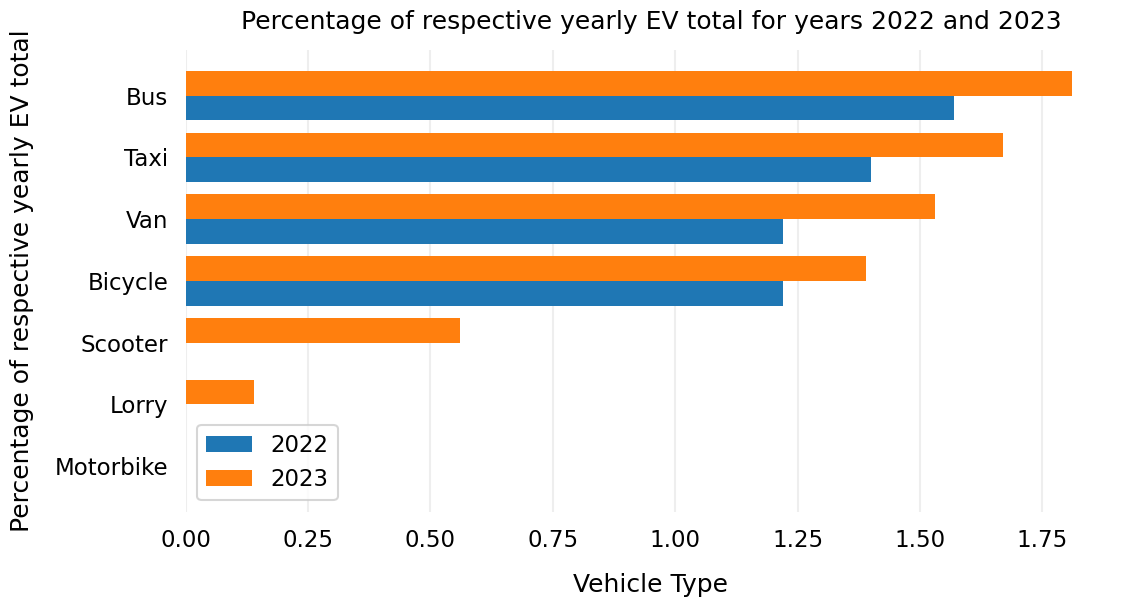

In [452]:
plot_1_df = vtypes_group_yr.copy()
plot_1_df = plot_1_df[plot_1_df['is_electric'] == 1]

total_evs = plot_1_df.groupby(['year'], as_index=False)['total_vehicles'].agg({'total_yr_evs': 'sum'})
plot_1_df = pd.merge(plot_1_df, total_evs, how='inner', on='year')
plot_1_df['perc_of_ev'] = (plot_1_df['total_vehicles'] / plot_1_df['total_yr_evs'] * 100).round(2)
plot_1_df = plot_1_df.sort_values('total_vehicles', ascending=True)

#
plot_1_df = plot_1_df[plot_1_df['type'] != 'Car']


fig, ax = plt.subplots(figsize=(12, 6))

ax.set_xlabel('Vehicle Type', labelpad=15)
ax.set_ylabel('Percentage of respective yearly EV total', labelpad=15)
ax.set_title('Percentage of respective yearly EV total for years 2022 and 2023', pad=15)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

ax.tick_params(bottom=False, left=False)
ax.set_axisbelow(True)
ax.yaxis.grid(False)
ax.xaxis.grid(True, color='#EEEEEE')

bar_width = 0.4

x = np.arange(plot_1_df['type'].nunique())

y2022 = plot_1_df.loc[plot_1_df['year'] == '2022', 'perc_of_ev']
y2023 = plot_1_df.loc[plot_1_df['year'] == '2023', 'perc_of_ev']

b1 = ax.barh(x, y2023, height=bar_width, label='2023')
b2 = ax.barh(x + bar_width, y2022, height=bar_width, label='2022')

ax.set_yticks(x + bar_width / 2)
ax.set_yticklabels(plot_1_df['type'].unique())

ax.legend(['2022', '2023'])

# for bar in ax.patches:
#   bar_val = bar.get_width()
#   text_x = bar.get_x() + bar.get_height() / 2
#   text_y = bar.get_y() + bar_val
#   ax.text(text_x, text_y, bar_val, ha='center', va='bottom', size=12)

plt.show()

  

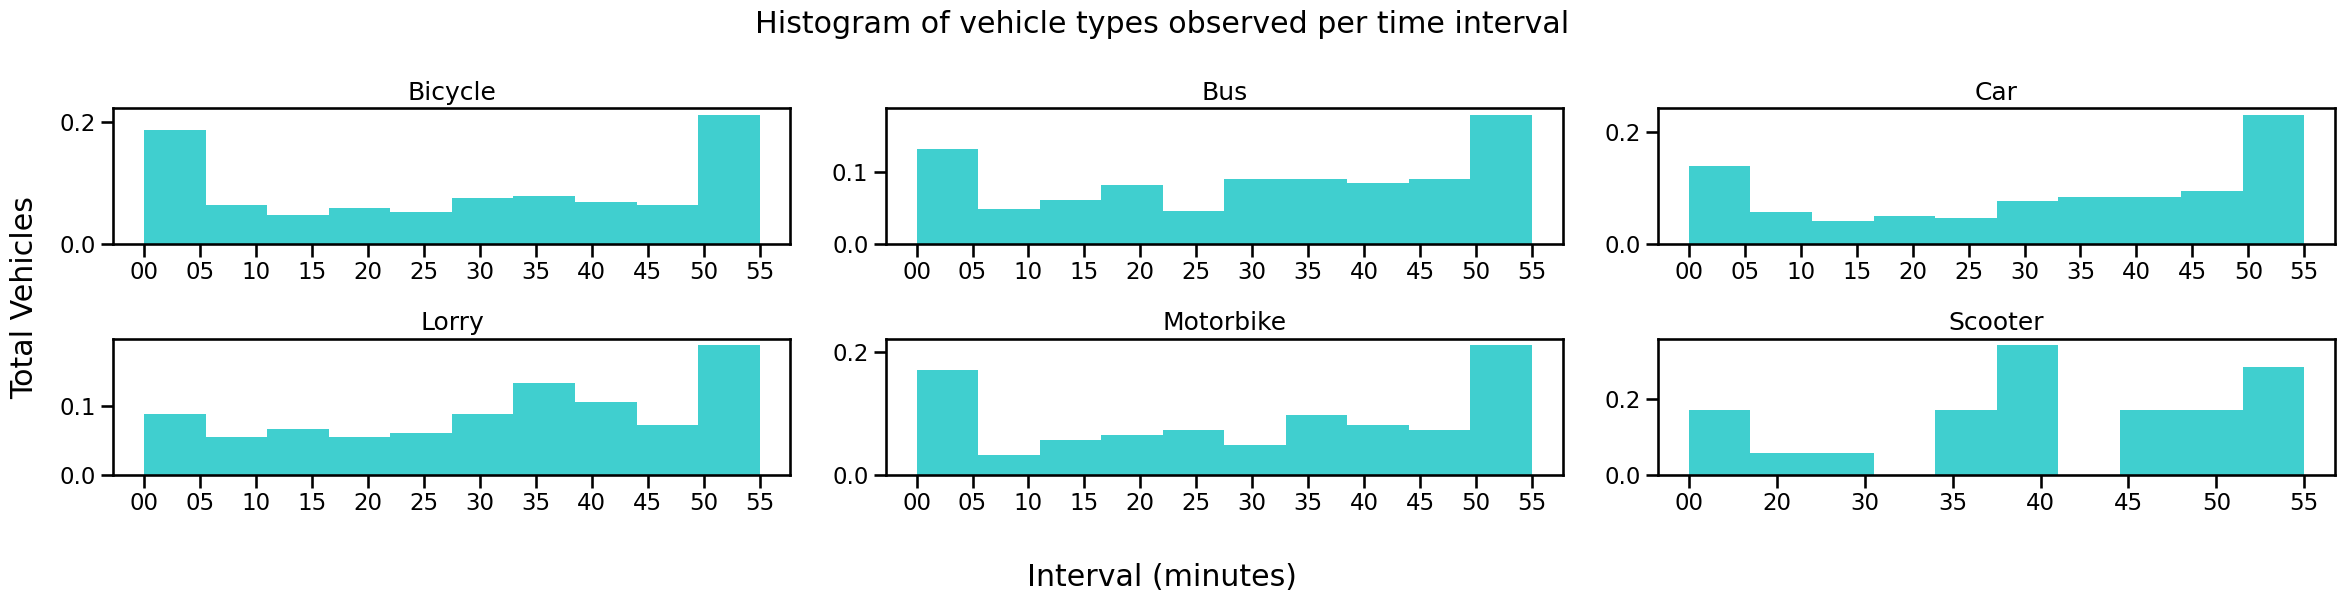

In [344]:
hist_plot_df = group_intervals_df.copy()   
hist_plot_df = hist_plot_df.sort_values(['minute'])

hist_plot_df = hist_plot_df.groupby(['minute', 'type'], as_index=False)['vehicle_count'].agg({'total_vehicles': 'sum'})
hist_plot_df['perc_of_vtype'] = hist_plot_df['total_vehicles'] / vtypes_group_yr.groupby(['type'])['total_vehicles'].transform('sum')
hist_plot_df['perc_of_vtype'] = hist_plot_df['perc_of_vtype'].round(2) * 100

fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(24, 6))
fig.suptitle('Histogram of vehicle types observed per time interval')
fig.supxlabel('Interval (minutes)')
fig.supylabel('Total Vehicles')

types = hist_plot_df['type'].unique()
ticker = 0
for i in range(2):
    for j in range(3):

        temp = hist_plot_df[hist_plot_df['type'] == types[ticker]]

        temp_hist = 

        axs[i, j].hist(temp['minute'], weights=temp['total_vehicles'], density=True, histtype='stepfilled', facecolor='c', alpha=0.75)
        axs[i, j].set_title(types[ticker])
        
        # axs[i, j].text(dabars.get_x() + dabars.get_width() / 2, dabars.get_height()+0.01, dabars.get_height(), ha='center', va='bottom') 

        ticker += 1

fig.tight_layout()
plt.show()

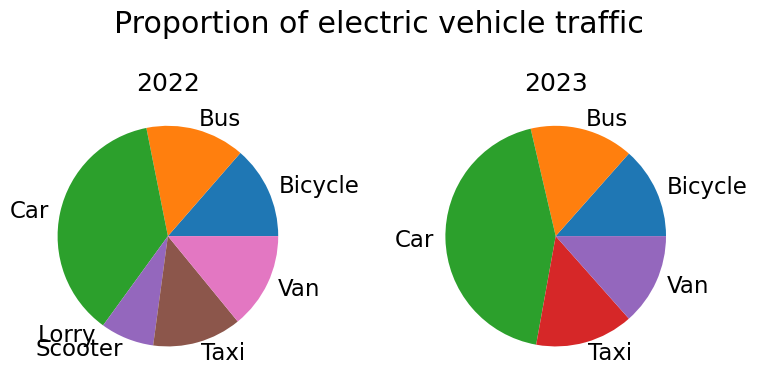

In [382]:
pie_df = pie_df_stage.copy()
pie_df = pie_df[pie_df['is_electric'] == 1]

pie_df = pie_df.groupby(['year', 'type'], as_index=False)['total_vehicles'].agg({'total_vehicles': 'sum'})

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))
fig.suptitle('Proportion of electric vehicle traffic')

years = pie_df['year'].unique()
ticker = 0
for i in range(2):

    temp = pie_df[pie_df['year'] == years[ticker]]

    axs[i].pie(temp['total_vehicles'], labels = temp['type'])
    axs[i].set_title(years[ticker])
    
    ticker += 1

fig.tight_layout()
plt.show()

In [ ]:
plot_1_df = vtypes_group_yr.copy()
plot_1_df = plot_1_df[plot_1_df['is_electric'] == 1]

sns.set_context('talk')

fig, ax = plt.subplots(figsize=(12, 6))

ax.set_xlabel('Vehicle Type', labelpad=15)
ax.set_ylabel('Occupancy', labelpad=15)
ax.set_title('Percentage of electric vehicles comparison by type between 2022 and 2023', pad=15)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

ax.tick_params(bottom=False, left=False)
ax.set_axisbelow(True)
ax.yaxis.grid(True, color='#EEEEEE')
ax.xaxis.grid(False)

bar_width = 0.4

x = np.arange(plot_1_df['type'].nunique())

b1 = ax.bar(x, plot_1_df.loc[plot_1_df['year'] == '2022', 'perc_of_vtype'], width=bar_width, label='2022')
b2 = ax.bar(x + bar_width, plot_1_df.loc[plot_1_df['year'] == '2023', 'perc_of_vtype'], width=bar_width, label='2023')

ax.set_xticks(x + bar_width / 2)
ax.set_xticklabels(plot_1_df['type'].unique())

ax.legend()

for bar in ax.patches:
  bar_val = bar.get_height()
  text_x = bar.get_x() + bar.get_width() / 2
  text_y = bar.get_y() + bar_val
  ax.text(text_x, text_y, bar_val, ha='center', va='bottom', size=12)

  